In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, 
    classification_report, silhouette_score, silhouette_samples
)
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.cm as cm

In [192]:
df = pd.read_csv('../data/processed/combined-swell-classification-hrv-train-dataset.csv')

In [193]:
val = pd.read_csv('../data/processed/combined-swell-classification-hrv-validation-dataset.csv')

In [194]:
test = pd.read_csv('../data/processed/combined-swell-classification-hrv-test-dataset.csv')

In [195]:
df = pd.concat([df, val]) # 352474 entries to train and validated combined

In [39]:
## NOTES ON FEATURES
# RR is the peak in a heartbeat
# RR interval (RRI) is the distance between peaks in milliseconds between beats from an ECG
# RMSDD is the square root of the mean distance between RR for a period of time
# RMSDD is used as HRV calculation based on one minute intervals
# SDNN is the standard deviaiton of all the RR intervals

## NOTES ON EXPERIMENT CONDITIONS
# Conditions are R: rest, N: no stress, T: time pressure, I: interruption 
# No stress - Allowed to work for a maximum 45 minutes but they don't know the duration 
# Interruption - Received 8 emails in the middle of the assigned task 
# Time Pressure - Time limit of 2/3 to complete task based on duration in no stress

## NOTES ON STRESS QUSTIONNAIRE TAKEN AFTER EVERY EXPERIMENT CONDITION

# NASA TLX - NASA Task Load Index is used as a measure of mental load: High, Medium, Low
# multi-dimensional rating for mental demand, physical demand, temporal deman, effort,
# performance, and frustration

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [43]:
df.columns

Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'condition', 'subject_id', 'MEAN_RR_LOG',
       'MEAN_RR_SQRT', 'TP_SQRT', 'MEDIAN_REL_RR_LOG', 'RMSSD_REL_RR_LOG',
       'SDSD_REL_RR_LOG', 'VLF_LOG', 'LF_LOG', 'HF_LOG', 'TP_LOG', 'LF_HF_LOG',
       'RMSSD_LOG', 'SDRR_RMSSD_LOG', 'pNN25_LOG', 'pNN50_LOG', 'SD1_LOG',
       'KURT_YEO_JONSON', 'SKEW_YEO_JONSON', 'MEAN_REL_RR_YEO_JONSON',
       'SKEW_REL_RR_YEO_JONSON', 'LF_BOXCOX', 'HF_BOXCOX', 'SD1_BOXCOX',
       'KURT_SQUARE', 'HR_SQRT', 'MEAN_RR_MEAN_MEAN_REL_RR', 'SD2_LF', 'HR_LF',
       'HR_HF', 'HF_VLF', 'NasaTLX class', 'Condition Label', 'NasaTLX Label'],
      dtype='object')

In [44]:
sorted(df['subject_id'].unique()), len(df['subject_id'].unique())

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 22)

In [45]:
# Participants 8, 11, 15 were been removed

In [46]:
df['condition'].unique()

array(['interruption', 'time pressure', 'no stress'], dtype=object)

In [47]:
df['NasaTLX class'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [48]:
df['NasaTLX Label'].unique()

array([2, 1, 0])

In [49]:
subjects = df['subject_id'].unique()
lengths = []
for subject in subjects:
    lengths.append(len(df[df['subject_id'] == subject]))
    print(f"{subject}: {len(df[df['subject_id'] == subject])}")
np.mean(lengths)
# Average of about 16,000 datapoints per subject

4: 17552
17: 16938
18: 16764
22: 13667
10: 17662
12: 17677
14: 17702
7: 15841
21: 14925
20: 13310
24: 14571
23: 12125
13: 14558
16: 19347
6: 18776
19: 17931
9: 14320
2: 17474
1: 17312
5: 16234
3: 14411
25: 13377


16021.545454545454

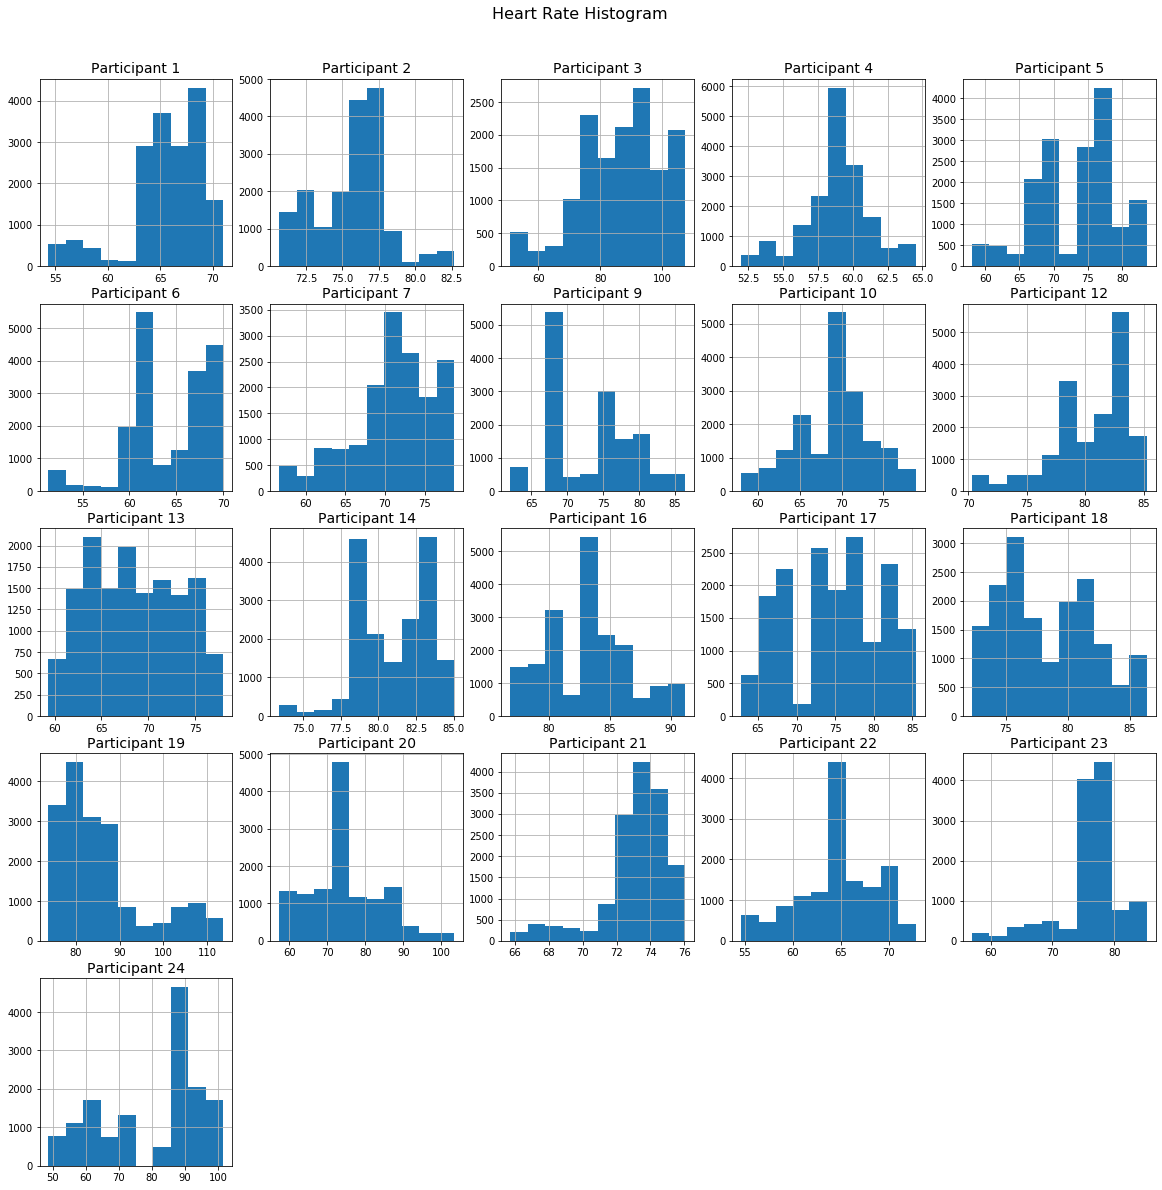

In [260]:
# Heart Rate Histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax, subject in zip(axs.flatten(), sorted(subjects)):
    df[df['subject_id'] == subject]['HR'].hist(ax=ax)
    ax.set_title(f'Participant {subject}', fontsize=14)
fig.delaxes(axs[-1, -1])
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -3])
fig.delaxes(axs[-1, -4])
fig.suptitle('Heart Rate Histogram', y=0.93, fontsize=16)
plt.savefig('Heart Rate Histogram.png')

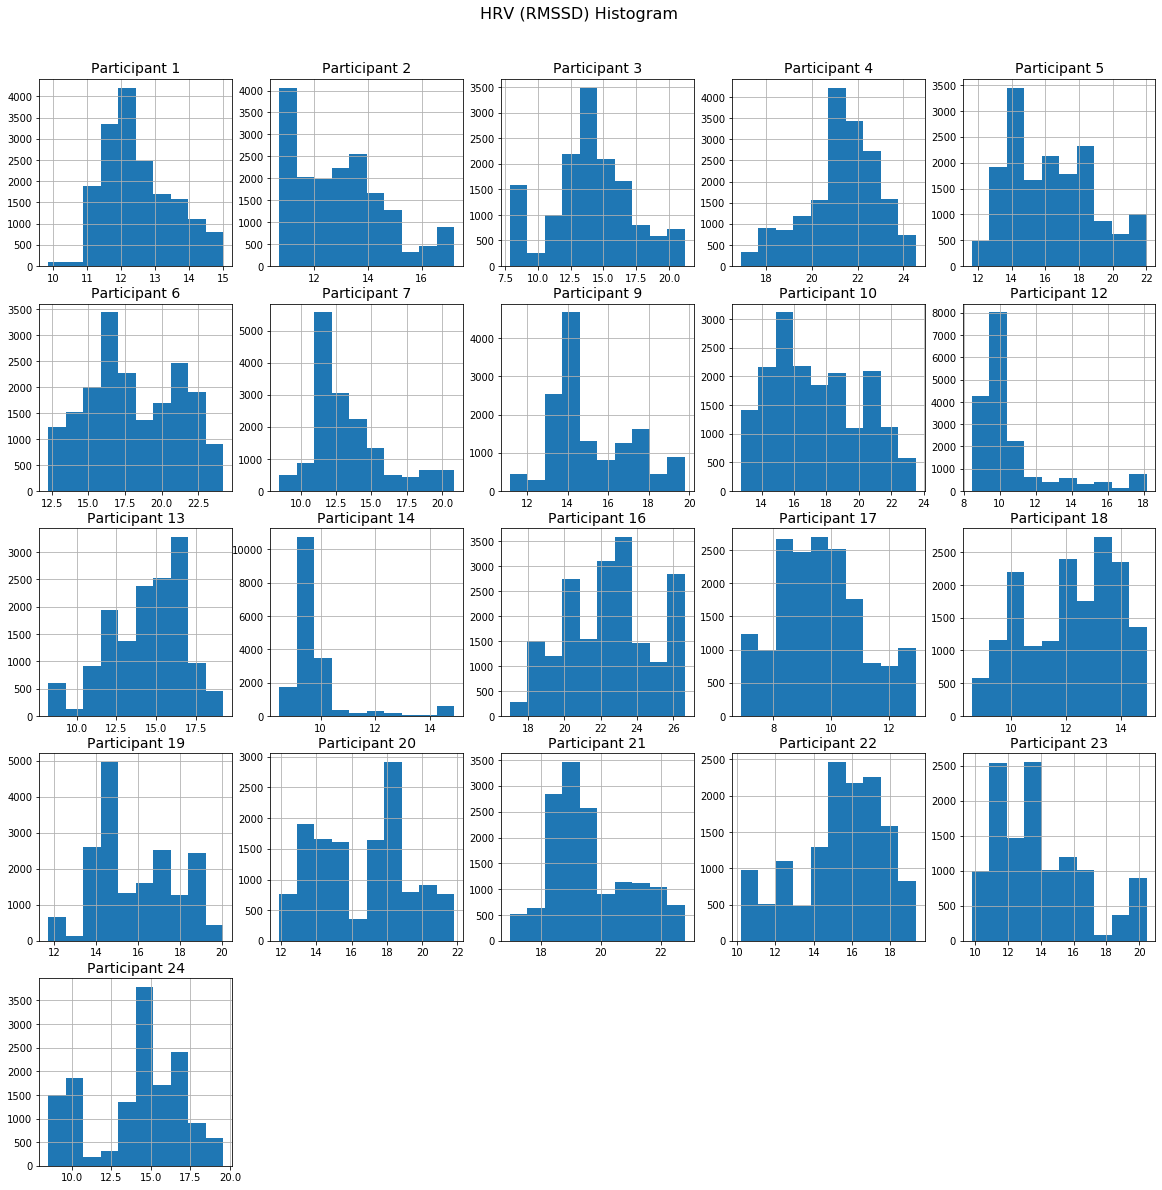

In [262]:
# RMSDD histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax, subject in zip(axs.flatten(), sorted(subjects)):
    df[df['subject_id'] == subject]['RMSSD'].hist(ax=ax)
    ax.set_title(f'Participant {subject}', fontsize=14)
fig.delaxes(axs[-1, -1])
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -3])
fig.delaxes(axs[-1, -4])
fig.suptitle('HRV (RMSSD) Histogram', y=0.93, fontsize=16)
plt.savefig('HRV (RMSSD) Histogram.png')

In [52]:
df[df['subject_id'] == 1][['condition', 'NasaTLX class']][40:50]

,condition,NasaTLX class
814,time pressure,medium
824,interruption,medium
830,no stress,medium
866,no stress,medium
874,time pressure,medium
880,time pressure,medium
894,no stress,medium
902,time pressure,medium
906,no stress,medium
915,no stress,medium


In [53]:
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,NasaTLX class,Condition Label,NasaTLX Label
0,1174.144734,1220.305100,146.274795,20.453938,20.453875,7.151424,52.018538,21.266667,1.933333,14.467900,...,0.099908,7.212388,2.199784e+07,0.153091,0.038591,43.650130,0.000447,high,1,2
1,895.342387,893.943175,56.174431,9.294380,9.294329,6.043914,67.278216,0.933333,0.000000,6.574276,...,0.203463,8.202330,2.879915e+07,0.241013,0.204811,6.144360,0.015995,high,1,2
2,764.218684,767.859965,77.160764,11.788299,11.787062,6.545539,79.342692,3.066667,0.000000,8.337493,...,0.138674,8.907452,-3.266219e+06,0.155760,0.113586,3.932715,0.013721,medium,1,1
3,854.776805,830.149445,84.950716,10.797540,10.796497,7.867599,70.867408,2.733333,0.200000,7.636824,...,0.698643,8.418278,-5.553280e+06,0.223233,0.131948,4.348861,0.033438,low,2,0
4,1093.290552,1121.317600,145.395568,17.550094,17.550090,8.284603,55.994337,16.066667,0.933333,12.413929,...,0.058267,7.482936,-6.849979e+07,0.215492,0.058790,33.929483,0.000479,medium,2,1


In [54]:
columns_to_drop = ['subject_id', 'HR', 'condition', 'Condition Label', 'NasaTLX class', 'NasaTLX Label']
main_columns_to_keep = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50']
# Mean RR: Mean of all RR intervals
# Median RR: Median of all RR intervals
# SDRR: Standard Deviation of all intervals
# RMSDD: Square root of the mean of the sum of the squares of the difference between adjacent RR intervals
# SDSD: Standard deviation of all interval of differences between adjacent RR intervals 
# SDRR_RMSDD: Ratio of SDRR over RMSSD
# HR: Heart Rate
# pNN25: % of adjacent RR intervals differing by more than 25 ms
# pNN50: % of adjacent RR intervals differing by more than 50 ms

In [196]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [100, 250, 500], 'max_depth': [2, 3]}

In [56]:
# Using just HR to predict stress 
X = df['HR'].values.reshape(-1, 1)
y = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf1 = GridSearchCV(rf, rf_grid)
clf1.fit(X_train, y_train)
# Accuracy Score for just using HR
accuracy_score(y_test, clf1.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4909156935507666

In [57]:
# Using just HRV to predict stress
X4 = df[['RMSSD']]
y4 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X4, y4)
clf2 = GridSearchCV(rf, rf_grid)
clf2.fit(X_train, y_train)
# Accuracy Score for just using HRV
accuracy_score(y_test, clf2.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4206924726789909

In [58]:
# Using HR and HRV to predict stress
X3 = df[['HR', 'RMSSD']]
# X3 = StandardScaler().fit_transform(X3)
y3 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X3, y3)
clf3 = GridSearchCV(rf, rf_grid)
clf3.fit(X_train, y_train)
# Accuracy Score for using HR + HV
accuracy_score(y_test, clf3.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4978381506825997

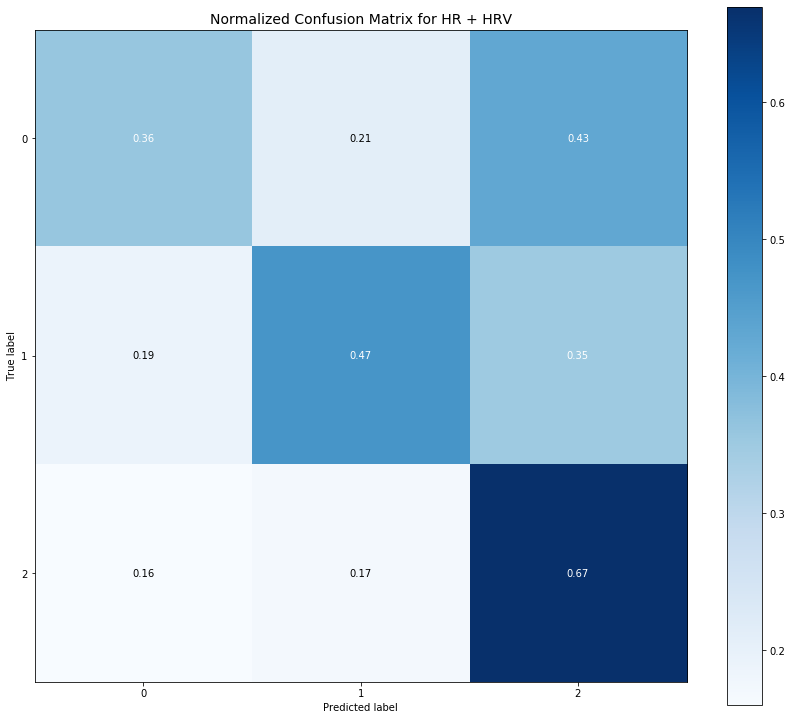

In [159]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(y_test, clf3.predict(X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('Normalized Confusion Matrix for HR + HRV', fontsize=14)
plt.savefig('Normalized Confusion Matrix for HR + HRV.png')

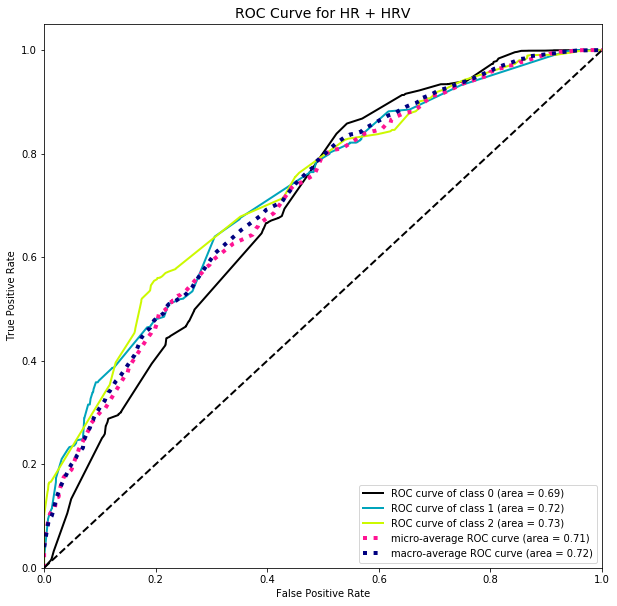

In [239]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_roc(y_test, clf3.predict_proba(X_test), ax=ax)
ax.set_title('ROC Curve for HR + HRV', fontsize=14)
plt.savefig('ROC curve for HR + HRV.png')

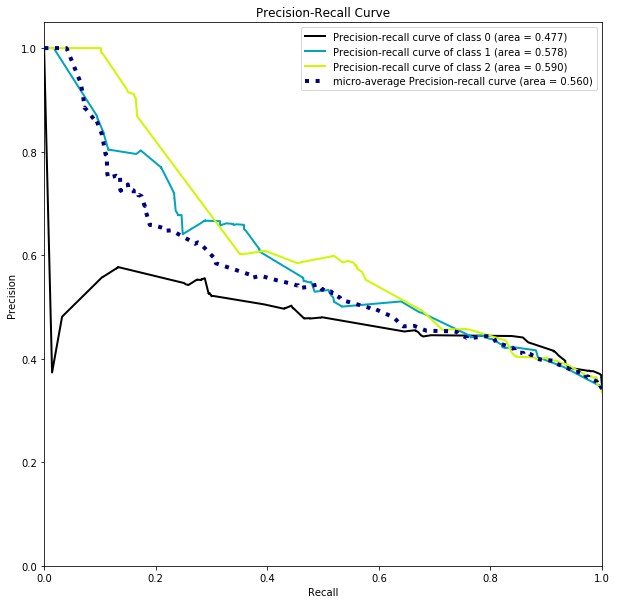

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_precision_recall(y_test, clf3.predict_proba(X_test), ax=ax)

In [197]:
df['RMSSD_LOG'] = np.log(df['RMSSD'])
df['RMSSD_SQUARED'] = df['RMSSD']**2

In [265]:
# Using Columns to Keep
X10 = df[COLUMNS_TO_KEEP]
X10 = StandardScaler().fit_transform(X10)
y10 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X10, y10)
clf10 = GridSearchCV(rf, rf_grid)
clf10.fit(X_train, y_train)
# Accuracy Score for using HR + HV
accuracy_score(y_test, clf10.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9785630794720775

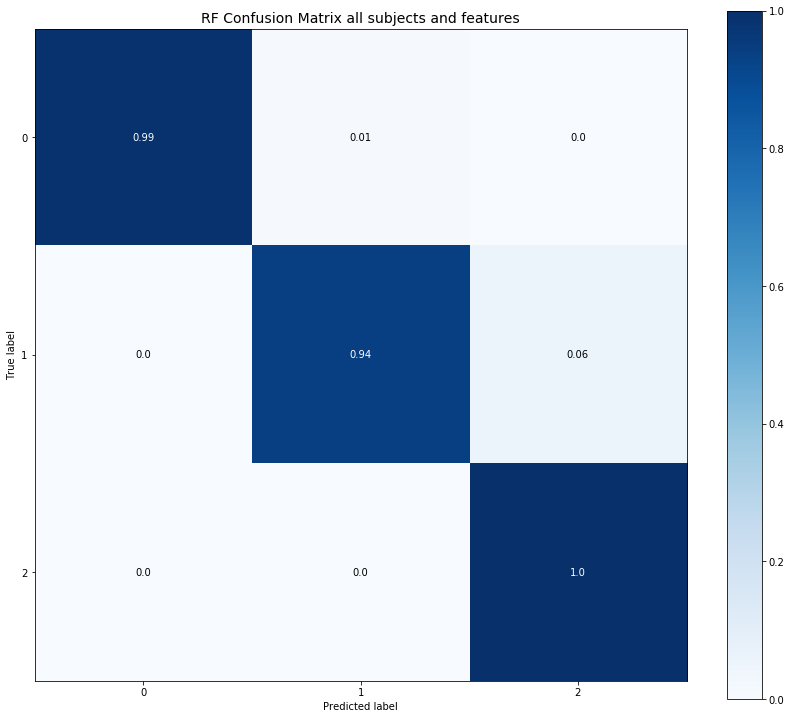

In [266]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(y_test, clf10.predict(X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('RF Confusion Matrix all subjects and features', fontsize=14)
plt.savefig('RF Confusion Matrix all subjects and features.png')

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

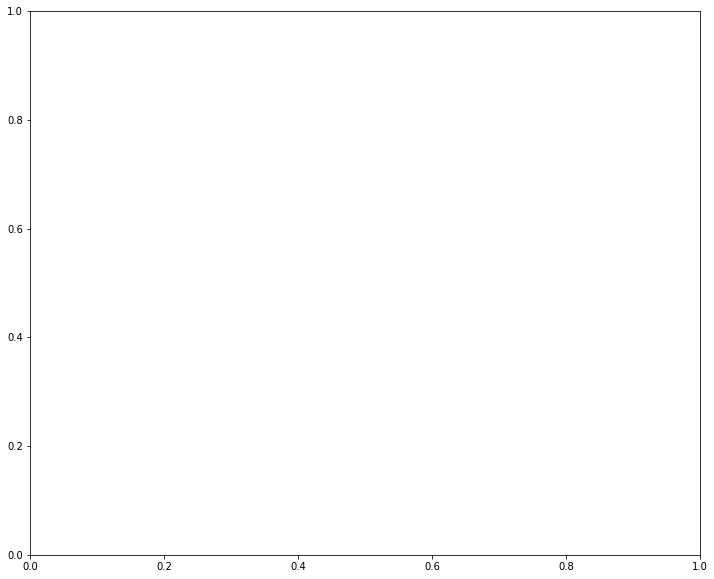

In [268]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(y_test, clf10.predict_proba(X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('RF ROC for all subjects and features', fontsize=14)
plt.savefig('RF ROC for all subjects and features.png')

In [198]:
POSSIBLE_COLUMNS = ['HF',
                    'HF_BOXCOX',
                    'HF_LF',
                    'HF_LOG',
                    'HF_NU',
                    'HF_PCT',
                    'HF_VLF',
                    'HR',
                    'HR_HF',
                    'HR_LF',
                    'HR_SQRT',
                    'KURT',
                    'KURT_REL_RR',
                    'KURT_SQUARE',
                    'KURT_YEO_JONSON',
                    'LF',
                    'LF_BOXCOX',
                    'LF_HF',
                    'LF_HF_LOG',
                    'LF_LOG',
                    'LF_NU',
                    'LF_PCT',
                    'MEAN_REL_RR',
                    'MEAN_REL_RR_YEO_JONSON',
                    'MEAN_RR',
                    'MEAN_RR_LOG',
                    'MEAN_RR_MEAN_MEAN_REL_RR',
                    'MEAN_RR_SQRT',
                    'MEDIAN_REL_RR',
                    'MEDIAN_REL_RR_LOG',
                    'MEDIAN_RR',
                    'RMSSD',
                    'RMSSD_LOG',
                    'RMSSD_SQUARED',
                    'RMSSD_REL_RR',
                    'RMSSD_REL_RR_LOG',
                    'SD1',
                    'SD1_BOXCOX',
                    'SD1_LOG',
                    'SD2',
                    'SD2_LF',
                    'SDRR',
                    'SDRR_REL_RR',
                    'SDRR_RMSSD',
                    'SDRR_RMSSD_LOG',
                    'SDRR_RMSSD_REL_RR',
                    'SDSD',
                    'SDSD_REL_RR',
                    'SDSD_REL_RR_LOG',
                    'SKEW',
                    'SKEW_REL_RR',
                    'SKEW_REL_RR_YEO_JONSON',
                    'SKEW_YEO_JONSON',
                    'TP',
                    'TP_LOG',
                    'TP_SQRT',
                    'VLF',
                    'VLF_LOG',
                    'VLF_PCT',
                    'higuci',
                    'pNN25',
                    'pNN25_LOG',
                    'pNN50',
                    'pNN50_LOG',
                    'sampen',
                    'NasaTLX Label']

# Top 31 Features were kept
COLUMNS_TO_KEEP =  ['RMSSD',
                    'SDRR_REL_RR',
                    'SD2_LF',
                    'SD1_LOG',
                    'SDSD',
                    'SDRR',
                    'HR_SQRT',
                    'LF_PCT',
                    'SD2',
                    'HF_LOG',
                    'HR',
                    'SDRR_RMSSD_LOG',
                    'SDRR_RMSSD',
                    'VLF_PCT',
                    'HF_PCT',
                    'higuci',
                    'MEDIAN_RR',
                    'HF',
                    'MEAN_RR_SQRT',
                    'MEAN_RR',
                    'HF_VLF',
                    'MEAN_RR_LOG',
                    'HF_BOXCOX',
                    'RMSSD_REL_RR',
                    'SDSD_REL_RR_LOG',
                    'HR_HF',
                    'RMSSD_REL_RR_LOG',
                    'SDSD_REL_RR',
                    'SDRR_RMSSD_REL_RR',
                    'SD1_BOXCOX',
                    'LF_BOXCOX',
                    'NasaTLX Label']

RF_GRID = {'n_estimators': [100, 250], 'max_depth': [2, 3]}

def random_included_and_excluded_df(df, total_excluded=5):
    random_subject_ids = np.random.choice(df['subject_id'].unique(), total_excluded, replace=False)
    print(random_subject_ids)
    excluded_df = df[df['subject_id'].isin(
        random_subject_ids)]
    included_df = df[~df['subject_id'].isin(
        random_subject_ids)]
    return included_df, excluded_df

# NasaTLX label is low, medium, high which is the mapping done in the study
def rf_for_subject_subset(included_df):
   X = included_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
   X = StandardScaler().fit_transform(X)
   y = included_df['NasaTLX Label'].values
   X_train, X_test, y_train, y_test = train_test_split(X, y)
   clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
   clf.fit(X_train, y_train)
   print(f'Accuracy Score for Included Subset: {accuracy_score(y_test, clf.predict(X_test))}')
   return clf, X_train, X_test, y_train, y_test

def test_rf_on_excluded_subset(clf, excluded_df):
    X_test = excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(f'Accuracy Score for Excluded Subset without Calibration: {accuracy_score(y_test, clf.predict(X_test))}')

def combined_included_excluded_without_calibration(included_df, excluded_df):
    clf = rf_for_subject_subset(included_df)[0]
    test_rf_on_excluded_subset(clf, excluded_df)

# Default sample set to around 6.25% of data
# This is not a great method to calibrate given sampled datapoints will be correlated with excluded datapoints
# Ideally this should be done with fresh data points through a cycle of scenarios early in the prediction process
def calibrated_rf_with_sample_of_excluded_subset(included_df, excluded_df, samples_per_subject=1000):
    for i in excluded_df['subject_id'].unique():
        random_sample = excluded_df[excluded_df['subject_id'] == i].sample(n=samples_per_subject)
        included_df = pd.concat([included_df, random_sample])
        # remove random sample from excluded subset
        excluded_df.drop(random_sample.index, inplace=True)

    calibrated_rf = rf_for_subject_subset(included_df)[0]
    X_test = excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(
        f'Accuracy Score for Excluded Subset with Calibrated RF: {accuracy_score(y_test, calibrated_rf.predict(X_test))}')
    return calibrated_rf

def test_on_validation_df(clf, validation_df):
    X_test = validation_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
    X_test = StandardScaler().fit_transform(X_test)
    y_test = validation_df['NasaTLX Label'].values
    print(f'Accuracy Score for Validation Subset without Calibration: {accuracy_score(y_test, clf.predict(X_test))}')

def rf_predictions_for_each_subject(df):
    predictions = []
    for i in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == i]
        X = subject_df
        X = X[COLUMNS_TO_KEEP]
        X = StandardScaler().fit_transform(X)
        y = subject_df['NasaTLX Label'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))
        print(f'Accuracy Score for Included Subject {i}: {accuracy_score(y_test, clf.predict(X_test))}')
    return predictions


In [270]:
len(COLUMNS_TO_KEEP)

32

In [199]:
included_df, excluded_df = random_included_and_excluded_df(df, total_excluded=5)

[24  2 16  3 21]


In [200]:
non_calibrated_rf, nc_X_train, nc_X_test, nc_y_train, nc_y_test = rf_for_subject_subset(included_df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subset: 0.7283365470951029


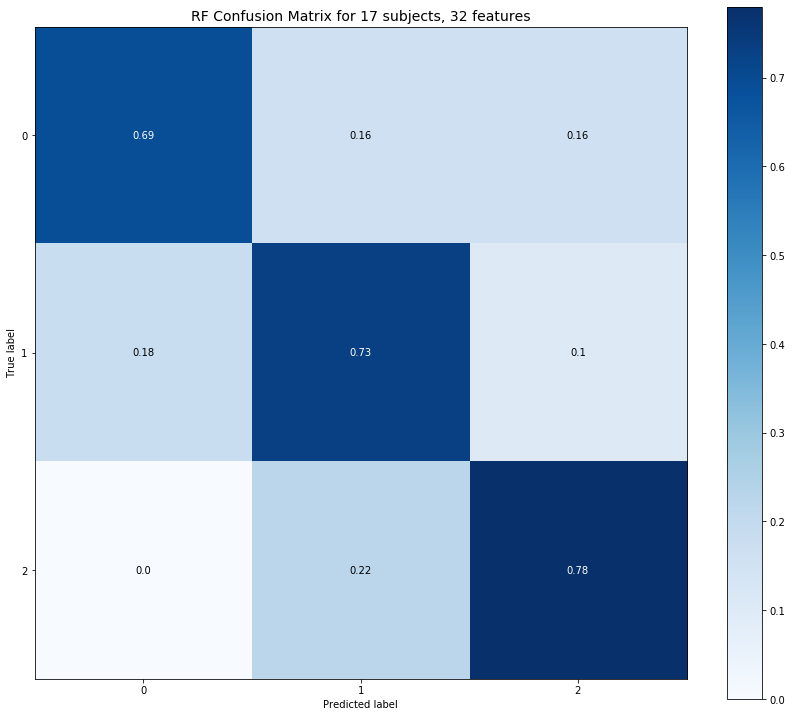

In [271]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(nc_y_test, non_calibrated_rf.predict(nc_X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('RF Confusion Matrix for 17 subjects, 32 features', fontsize=14)
plt.savefig('RF Confusion Matrix for 17 subjects, 32 features.png')

In [273]:
sorted(list(zip(COLUMNS_TO_KEEP, non_calibrated_rf.best_estimator_.feature_importances_)), key=lambda x: x[1])

[('LF_PCT', 0.0009242267162711038),
 ('SDSD', 0.00646671771236396),
 ('RMSSD', 0.007157158274055446),
 ('VLF_PCT', 0.007336967749545577),
 ('SD2', 0.008073849710744324),
 ('SD1_LOG', 0.008724078408330052),
 ('SDRR', 0.009274068876158621),
 ('HR', 0.009508259475049973),
 ('MEAN_RR_SQRT', 0.010855593784452612),
 ('SD2_LF', 0.010888947650463611),
 ('HR_HF', 0.012155185827677318),
 ('HR_SQRT', 0.014291084308558761),
 ('SDRR_REL_RR', 0.014653613851134666),
 ('HF_LOG', 0.015696556392075112),
 ('MEAN_RR', 0.017755277306835474),
 ('MEAN_RR_LOG', 0.018240999094360964),
 ('HF', 0.018989356091228395),
 ('MEDIAN_RR', 0.01909855897363679),
 ('SDRR_RMSSD_LOG', 0.020312611250773854),
 ('HF_VLF', 0.023253326968153763),
 ('SDRR_RMSSD', 0.02752354437531868),
 ('HF_PCT', 0.029530932569530415),
 ('HF_BOXCOX', 0.03370920138476525),
 ('RMSSD_REL_RR_LOG', 0.03600283779292289),
 ('SDSD_REL_RR_LOG', 0.036836632292011035),
 ('SDSD_REL_RR', 0.039137618825601024),
 ('RMSSD_REL_RR', 0.04285221225738648),
 ('LF_BOX

In [278]:
COLUMNS_TO_KEEP.remove('NasaTLX Label')

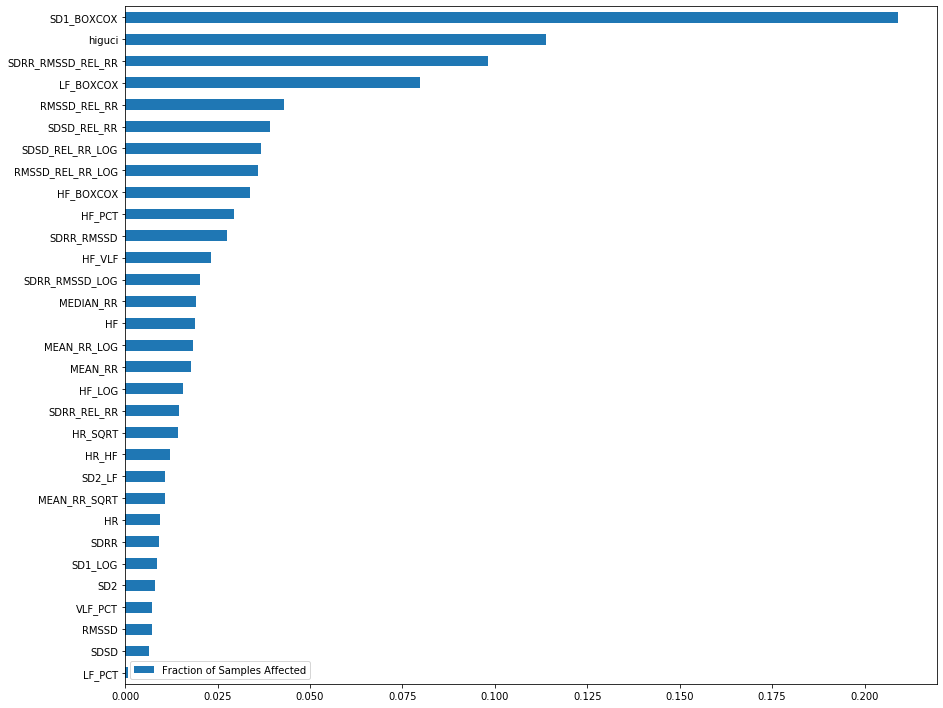

In [280]:
fig, ax = plt.subplots(figsize=(12, 10))
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : non_calibrated_rf.best_estimator_.feature_importances_},
                           index=COLUMNS_TO_KEEP)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
plt.tight_layout()
feat_scores.plot(ax=ax, kind='barh')
plt.savefig('Feature Importances for RF with 17 subjects, 32 features.png')

In [182]:
non_calibrated_rf.best_params_

{'max_depth': 3, 'n_estimators': 250}

In [210]:
included_df['subject_id'].unique()

array([ 4, 17, 18, 22, 10, 12, 14,  7, 20, 23, 13,  6, 19,  9,  1,  5, 25])

In [201]:
test_rf_on_excluded_subset(non_calibrated_rf, excluded_df)

Accuracy Score for Excluded Subset without Calibration: 0.06256813001684669


In [202]:
calibrated_rf = calibrated_rf_with_sample_of_excluded_subset(included_df, excluded_df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subset: 0.7267839333978927
Accuracy Score for Excluded Subset with Calibrated RF: 0.07390872358746771


In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(nc_y_test, calibrated_rf.predict(nc_X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('RF Confusion Matrix for 17 subjects, 32 features', fontsize=14)
plt.savefig('RF Confusion Matrix for 17 subjects, 32 features.png')

In [211]:
calibrated_rf = calibrated_rf_with_sample_of_excluded_subset(included_df, excluded_df, 500)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subset: 0.7272833347918672
Accuracy Score for Excluded Subset with Calibrated RF: 0.08427899062804452


In [76]:
def rf_predictions_for_each_subject(df):
    predictions = []
    for i in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == i]
        X = subject_df
        X = X[COLUMNS_TO_KEEP]
        X = StandardScaler().fit_transform(X)
        y = subject_df['NasaTLX Label'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))
        print(f'Accuracy Score for Included Subject {i}: {accuracy_score(y_test, clf.predict(X_test))}')
    return predictions

In [77]:
predictions = rf_predictions_for_each_subject(df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 4: 0.9425706472196901


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 17: 0.9723730814639906


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 18: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 22: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 10: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 12: 0.998868778280543


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 14: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 7: 0.9646553900530169


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 21: 0.9983922829581994


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 20: 0.9750600961538461


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 24: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 23: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 13: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 16: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 6: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 19: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 9: 0.9988826815642458


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 2: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 1: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 5: 0.9990145355999015


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 3: 0.9233971690258118


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 25: 1.0


In [222]:
Scores = [[4, 0.9425706472196901],
[17, 0.9723730814639906],
[18, 1.0],
[22, 1.0],
[10, 1.0],
[12, 0.998868778280543],
[14, 1.0],
[7, 0.9646553900530169],
[21, 0.9983922829581994],
[20, 0.9750600961538461],
[24, 1.0],
[23, 1.0],
[13, 1.0],
[16, 1.0],
[6, 1.0],
[19, 1.0],
[9, 0.9988826815642458],
[2, 1.0],
[1, 1.0],
[5, 0.9990145355999015],
[3, 0.9233971690258118],
[25, 1.0]]
scores = np.array(Scores)

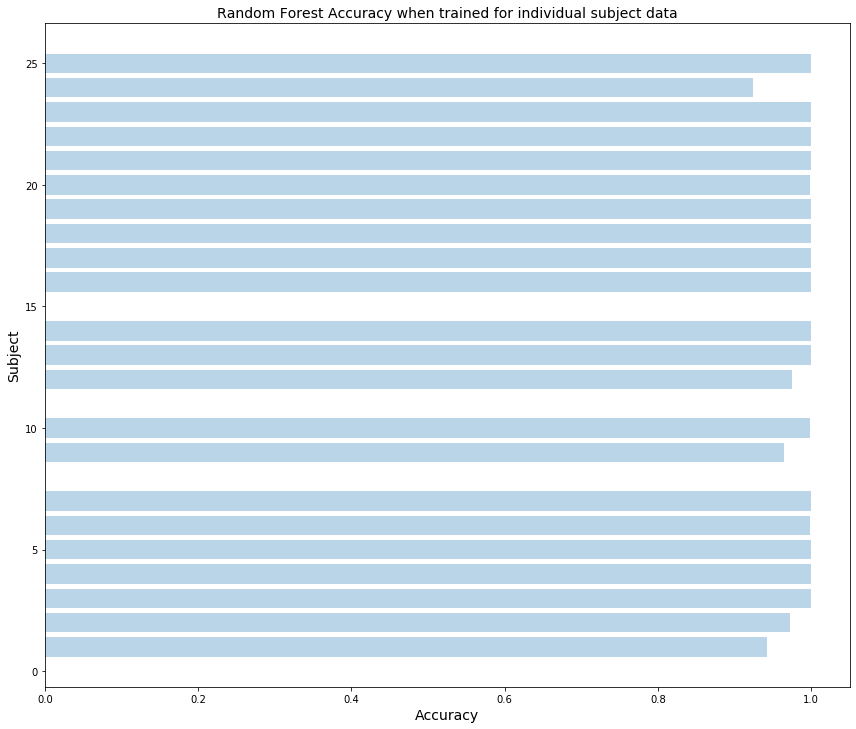

In [259]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(sorted(scores[:,0]), scores[:,1], alpha=0.3)
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Subject', fontsize=14)
plt.tight_layout()
ax.set_title('Random Forest Accuracy when trained for individual subject data', fontsize=14)
plt.savefig('Random Forest Accuracy for individual data.png')

In [217]:
# Gradient Boosting
def gbc_for_subject_subset(included_df):
   X = included_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
   X = StandardScaler().fit_transform(X)
   y = included_df['NasaTLX Label'].values
   X_train, X_test, y_train, y_test = train_test_split(X, y)
   clf = GridSearchCV(GradientBoostingClassifier(), RF_GRID)
   clf.fit(X_train, y_train)
   print(f'Accuracy Score for Included Subset: {accuracy_score(y_test, clf.predict(X_test))}')
   return clf, X_train, X_test, y_train, y_test

def test_gbc_on_excluded_subset(clf, excluded_df):
    X_test = excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(f'Accuracy Score for Excluded Subset without Calibration: {accuracy_score(y_test, clf.predict(X_test))}')

def gbc_combined_included_excluded_without_calibration(included_df, excluded_df):
    clf = gbc_for_subject_subset(included_df)[0]
    test_gbc_on_excluded_subset(clf, excluded_df)

# Default sample set to around 6.25% of data
# This is not a great method to calibrate given sampled datapoints will be correlated with excluded datapoints
# Ideally this should be done with fresh data points through a cycle of scenarios early in the prediction process
def calibrated_gbc_with_sample_of_excluded_subset(included_df, excluded_df, samples_per_subject=1000):
    for i in excluded_df['subject_id'].unique():
        random_sample = excluded_df[excluded_df['subject_id'] == i].sample(n=samples_per_subject)
        included_df = pd.concat([included_df, random_sample])
        # remove random sample from excluded subset
        excluded_df.drop(random_sample.index, inplace=True)

    calibrated_gbc = gbc_for_subject_subset(included_df)[0]
    X_test = excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(
        f'Accuracy Score for Excluded Subset with Calibrated RF: {accuracy_score(y_test, calibrated_gbc.predict(X_test))}')
    return calibrated_rf

In [218]:
non_calibrated_gbc, gbc_X_train, gbc_X_test, gbc_y_train, gbc_y_test = gbc_for_subject_subset(included_df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subset: 0.999749768167567


In [224]:
non_calibrated_gbc.best_params_

{'max_depth': 3, 'n_estimators': 250}

In [242]:
sorted(list(zip(COLUMNS_TO_KEEP, non_calibrated_gbc.best_estimator_.feature_importances_)), key=lambda x: x[1])

[('RMSSD_REL_RR_LOG', 0.0007055179200623144),
 ('HF_LOG', 0.0019535795100614896),
 ('HF_PCT', 0.0022337215745072353),
 ('HF', 0.002496693366761351),
 ('SDSD', 0.002518440277242483),
 ('LF_PCT', 0.004103076155674134),
 ('RMSSD_REL_RR', 0.00470068814267647),
 ('SD1_LOG', 0.00480656686784162),
 ('SDSD_REL_RR', 0.005616687639278524),
 ('RMSSD', 0.007414944238799021),
 ('HR_HF', 0.007771384573500834),
 ('MEAN_RR_SQRT', 0.007796773824819572),
 ('SDSD_REL_RR_LOG', 0.009076783729407773),
 ('SD2_LF', 0.009870013656127996),
 ('SDRR_RMSSD_LOG', 0.010397697963691353),
 ('HF_VLF', 0.011003691576057798),
 ('SDRR_REL_RR', 0.011068979505880067),
 ('MEAN_RR_LOG', 0.011372881062741548),
 ('VLF_PCT', 0.014081128655009248),
 ('SD2', 0.01570670799388167),
 ('MEAN_RR', 0.016589505863290714),
 ('HR_SQRT', 0.016736453306979912),
 ('SDRR_RMSSD_REL_RR', 0.021582294665465407),
 ('HR', 0.02161206534171964),
 ('SDRR_RMSSD', 0.02168180891699676),
 ('SDRR', 0.022346335154563555),
 ('MEDIAN_RR', 0.05336244778104673),

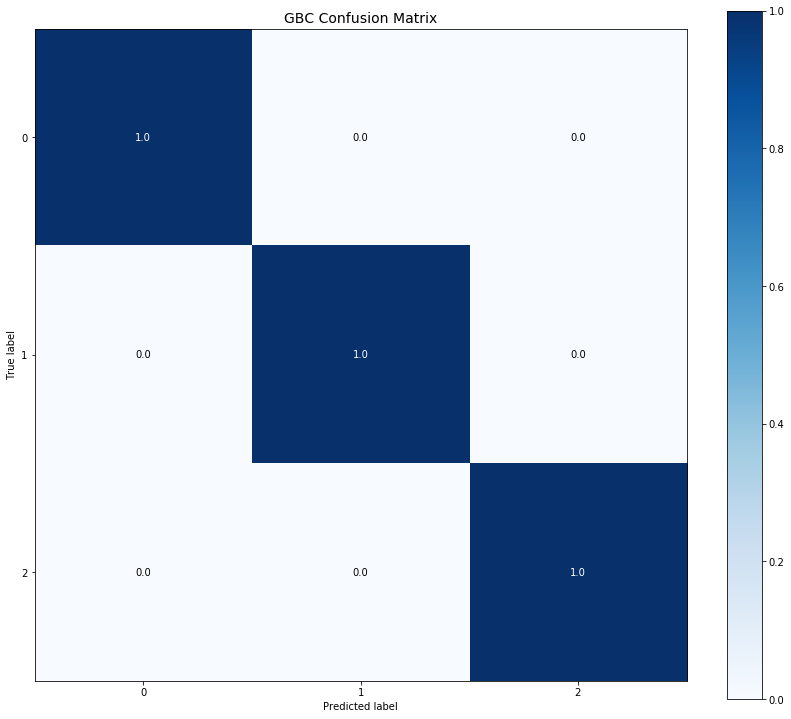

In [227]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(gbc_y_test, non_calibrated_gbc.predict(gbc_X_test), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('GBC Confusion Matrix', fontsize=14)
plt.savefig('GBC Confusion Matrix.png')

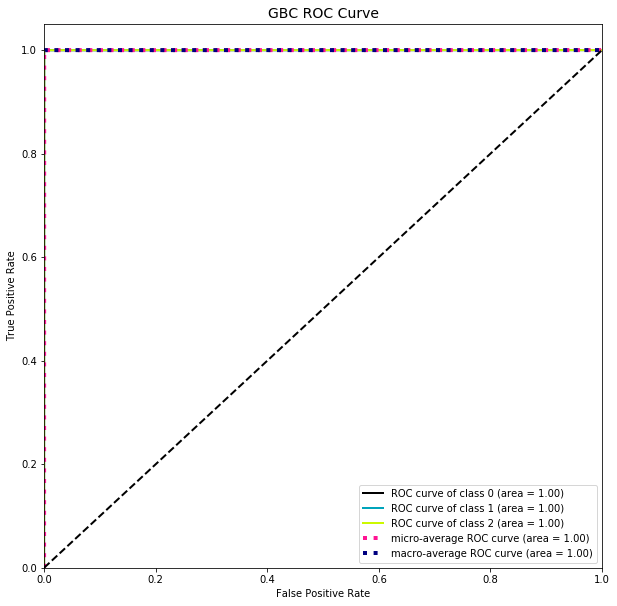

In [238]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_roc(gbc_y_test, non_calibrated_gbc.predict_proba(gbc_X_test), ax=ax)
ax.set_title('GBC ROC Curve', fontsize=14)
plt.savefig('GBC ROC Curve.png')

In [219]:
test_gbc_on_excluded_subset(non_calibrated_gbc, excluded_df)

Accuracy Score for Excluded Subset without Calibration: 0.1825541666094927


In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : non_calibrated_gbc.best_estimator_.feature_importances_},
                           index=COLUMNS_TO_KEEP)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
plt.tight_layout()
feat_scores.plot(ax=ax, kind='barh')
plt.savefig('Feature Importances for GBC with 17 subjects, 32 features.png')

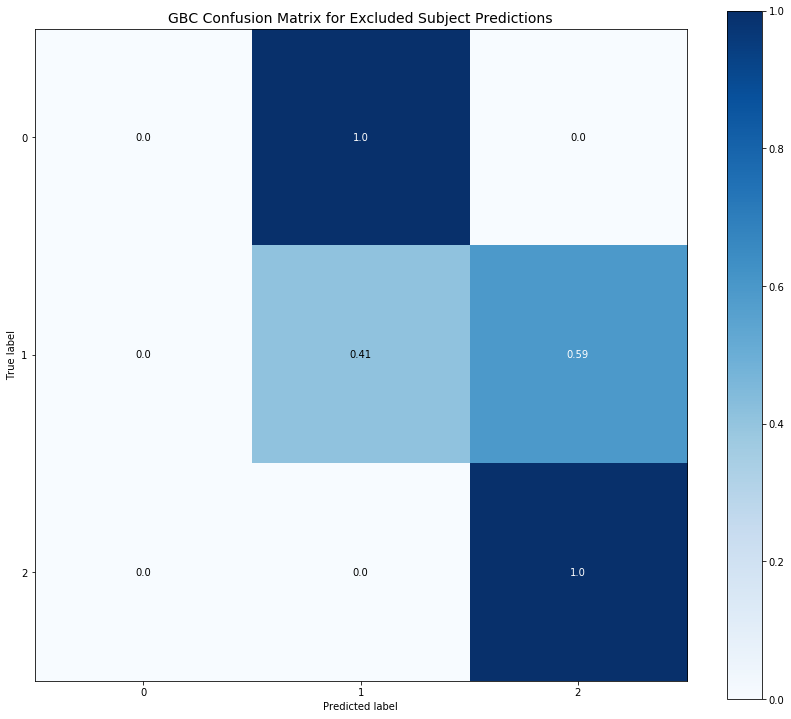

In [229]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(excluded_df['NasaTLX Label'].values, non_calibrated_gbc.predict(excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')), normalize=True, ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('GBC Confusion Matrix for Excluded Subject Predictions', fontsize=14)
plt.savefig('GBC Confusion Matrix for Excluded Subject Predictions.png')

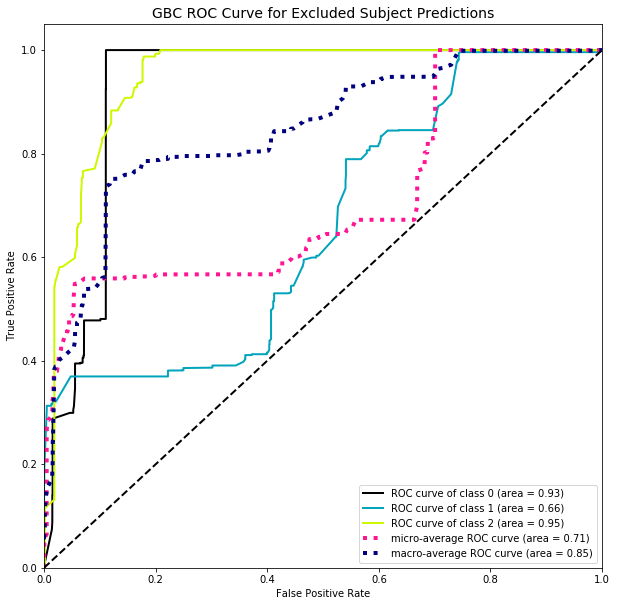

In [237]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_roc(excluded_df['NasaTLX Label'].values, non_calibrated_gbc.predict_proba(excluded_df[COLUMNS_TO_KEEP].drop(columns='NasaTLX Label')), ax=ax)
ax.set_title('GBC ROC Curve for Excluded Subject Predictions', fontsize=14)
plt.savefig('GBC ROC Curve for Excluded Subject Predictions.png')

In [220]:
calibrated_gbc = calibrated_gbc_with_sample_of_excluded_subset(included_df, excluded_df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subset: 0.9992339601370199
Accuracy Score for Excluded Subset with Calibrated RF: 0.5506081250831276


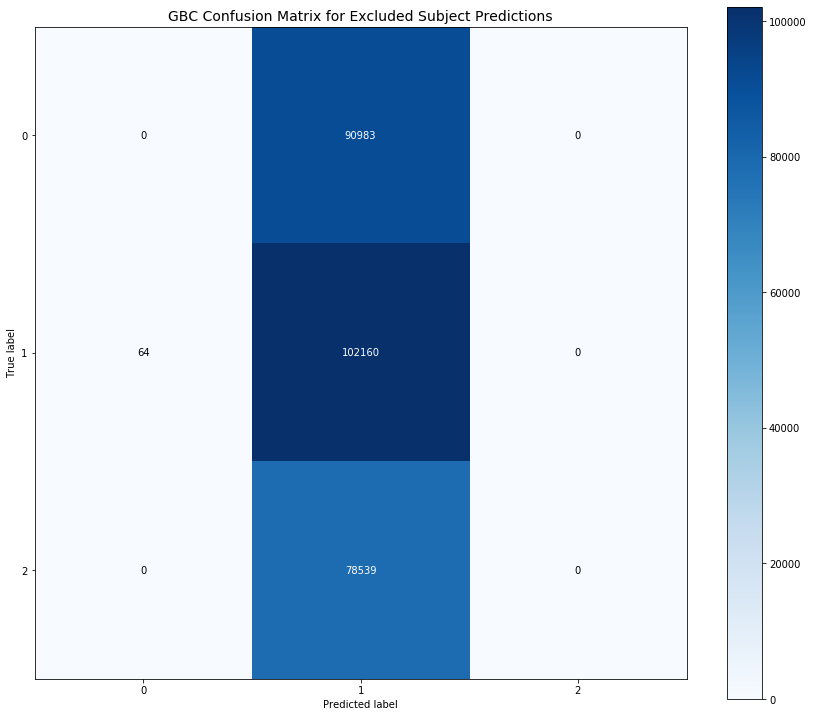

In [285]:
fig, ax = plt.subplots(figsize=(12, 10))
skplt.metrics.plot_confusion_matrix(included_df['NasaTLX Label'].values, calibrated_gbc.predict(included_df[COLUMNS_TO_KEEP]), ax=ax)
plt.tight_layout()
b, t=plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
ax.set_title('GBC Confusion Matrix for Excluded Subject Predictions', fontsize=14)
plt.savefig('GBC Confusion Matrix for Excluded Subject Predictions.png')